<b>Ashutosh Kanitkar (ask2261@columbia.edu)

Shahen Mirzoyan (sm4775@columbia.edu)

Github: ash151, mirzoyans</b>



We would like to begin our report with a thank you to <b>Professor Mamykina </b> for selecting us to contribute to her ongoing study of diabetes patients, and to <b>Professor Vintch</b> for allowing us to take this task on as our final course project. Beause this is a real world project, it gave us the opportunity to learn how actual data scientists would go about their work. We value this experience a lot, and it has taught us substationally about the importance of data preprocessing and thinking carefully about the practical and business constraints of a problem, which are typically not emphasized in an academic context. We would also like to thank Mitchell Elliot, a graduate student in Professor Mamykina's lab. He helped us greatly in figuring out our pipeline, providing us with user data, and giving us valuable advice. Our meetings with him were very informative.


<b>Goal of our project:</b>

Our task is to build a food recommender system for diabetic users of the Mealyzer app. The high level goal of our project is to recommend items to users which we believe users have a high probability of liking, and which fit into general macronutrient constraints that are specific to each individual's health needs. 

<b>Dataset information:</b>

Our dataset consists of csv files for each user which has fields for user id, meal id, meal title, meal ingredients, and general macronutrient information about each meal estimated by an expert dietician. In total, we had 67 unique users at the time we began the project. At the time of finishing this project, the number of users has grown to 82. However, our models have only been trained and tested on data from the original 67 users. Due to confidentiality reasons, we cannot upload our original dataset to Github. We've spoken to Professor Vintch regarding this, and was told that this was okay for this project.

We have 4059 interactions related to 67 users.
Hence on an average user has 177.567 interaction(Has logged about eating 177.567 items)
Hence we decide that all users who have eaten less than 50 interaction fall under cold start users(will use content based recommendation for them)

<b>Data preprocessing:</b>

In order to analyze our dataset properly, we need to tokenize user meal descriptions into components, so that we can analyze similarity between foods consumed. This was done using the Nutritionix API, which uses natural language tools to transform a a query such as "fried chicken, eggs, and half cup of noodles" into individual food items with macronutrient information about each component. Nutritionix also takes care of the problem that our users are not all English-speakers, as it handles queries in several other languages. All of the scripts we wrote to preprocess our datasets can be found in preprocessing.py. The most important function in this module is logs_to_macros(), which takes a raw csv file for a given user and transforms it into a new dataframe consisting of individual food items for the user, with the associated meal id preserved.

One decision that we made at this stage was to use the longer of "meal title" and "meal ingredients" as the natural language query. This is because we noticed a lot of users writing non-informative text for the meal title, such as "hello"  while descibing the meal more accurately in the ingredients field, or vice versa. As a general rule of thumb, the longer of the two entries tends to be more descriptive of the meal.

When the preprocessing.py script is run in any directory, it procecesses the contents of that directory and all subdirectories looking for files titled "mealyzer_data.csv." In any folder that it finds this filename, it generates a new file titled "nutritionix_preprocessed.csv" which contains a detailed breakdown of each meal according to the description above.

The preprocessing package also includes a merge_files() function. The intended use of this function is to combine all of these resulting preprocessed dataframes into one large dataframe, which is what our recommendation functions use. Its default output file is titled "preprocessed_merged.csv."

Our preprocessing pipeline relies heavily on the Nutritionix API, which has a very limiting number of API calls for our free-tier account. For this reason, if our methods are to be scaled, we would need to upgrade to an account that allows for more API queries, or look for other options such as building a natural language processing engine of our own.

In [211]:
import pandas as pd
import numpy as np
import lenskit.crossfold as xf
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import operator as op
from sklearn.metrics.pairwise import euclidean_distances
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from collections import defaultdict
from surprise import NMF
from surprise import KNNWithZScore
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
from pathlib import Path

In [286]:
#Just wanted to show you how the data was. in sense that ingredients contained were like fried shrimp,cheese,everything together   
uncleandata=pd.read_csv('mealyzer_data.csv')
uncleandata.head()

,user_id,meal_id,eaten_at,title,ingredients,kind,photo_file_name,carbs_eval,protein_eval,fat_eval,...,postmeal_bg,postmeal_bg_time,eval_calories_computed,eval_proportion_carbs,eval_proportion_protein,eval_proportion_fat,user_calories_computed,user_proportion_carbs,user_proportion_protein,user_proportion_fat
0,24,811,2771.445882,Taco fried shrimp And spinach salad,"Fried shrimp corn meal crusted, tortia, salsa....",dinner,cdv_photo_001.jpg,57,22,35,...,94.0,2805.0,631,0.361331,0.139461,0.499208,559,0.336315,0.100179,0.563506
1,24,812,3260.292491,Latte,"Espresso, 4oz 1% milk",morning_snack,cdv_photo_002.jpg,7,4,1,...,89.0,3320.0,53,0.528302,0.301887,0.169811,25,0.640000,0.000000,0.360000
2,24,813,3335.071067,0% fage yogurt with nuts,"6oz fage yogurt 0% 1.5 serving mixed nuts, 1tb...",breakfast,cdv_photo_003.jpg,29,30,28,...,85.0,3425.0,488,0.237705,0.245902,0.516393,540,0.266667,0.133333,0.600000
3,24,814,3709.310729,Apple and peanut butter,Granny Smith Apple 1 serving of peanut butter,lunch,cdv_photo_004.jpg,29,4,8,...,97.0,3755.0,204,0.568627,0.078431,0.352941,147,0.598639,0.217687,0.183673
4,24,819,4079.171643,Steak,"Steak tomatoes corn eggplan, onions, sausage ....",dinner,cdv_photo_001.jpg,22,45,14,...,92.0,4130.0,394,0.223350,0.456853,0.319797,330,0.363636,0.363636,0.272727


In [4]:


a=pd.read_csv('us0.csv') 

a.drop('Unnamed: 0',axis=1,inplace=True)

In [58]:
#THIS is how one of our preprocessed files looks for one user(we have 67 of such files) These 67 files were result of previous preproceesing which was done by preprocessing.py file
a

,user_id,meal_id,item,carbs,protein,fat,calories,fiber
0,24,811,fried shrimp,2.72,1.55,2.28,37.58,0.18
1,24,811,corn meal,93.81,9.91,4.38,441.64,8.91
2,24,811,salsa,2.39,0.55,0.06,10.44,0.68
3,24,811,spinach,6.75,5.35,0.47,41.40,4.32
4,24,811,bacon,0.59,11.70,12.11,161.46,0.00
...,...,...,...,...,...,...,...,...
447,24,954,romaine lettuce,20.60,7.70,1.88,106.42,13.15
448,24,954,lemon,7.83,0.92,0.25,24.36,2.35
449,24,954,olive oil,0.00,0.00,13.50,119.34,0.00
450,24,955,espresso,0.49,0.04,0.05,2.66,0.00


In [264]:
a.dropna(inplace=True)


In [19]:
n_users=67

Because our dataset deals with implicit data (users don't rate their meals-- we just know that they've consumed them) we are dealing with an implicit feedback dataset. We infer a user's rating of an item as the number of times the user has consumed the item. Hence our Rating Scale is now from 0 to 35.

In [9]:
e=(a['item'].value_counts())

e.index_name='Item'

e1=e.reset_index()

e1.columns = [
  'item',
  'Rating'
]

In [267]:
#When you convert implicit rating into explicit rating this is how it looks sans index1
e1

,item,Rating,index1
0,espresso,28,0.00
1,mixed nuts,24,0.00
2,1% milk,19,0.01
3,chia seeds,18,0.02
4,oats,17,0.02
...,...,...,...
140,italian wedding soup,1,0.97
141,mushrooms fried,1,0.97
142,carrot,1,0.98
143,2% milk,1,0.99


In [12]:
df = pd.merge(a, e1, how='inner', on=['item'])

#Intermediate File for user 24 
df

,user_id,meal_id,item,carbs,protein,fat,calories,fiber,Rating
0,24,811,fried shrimp,2.72,1.55,2.28,37.58,0.18,1
1,24,811,corn meal,93.81,9.91,4.38,441.64,8.91,1
2,24,811,salsa,2.39,0.55,0.06,10.44,0.68,1
3,24,811,spinach,6.75,5.35,0.47,41.40,4.32,9
4,24,850,spinach,6.75,5.35,0.47,41.40,4.32,9
...,...,...,...,...,...,...,...,...,...
441,24,950,wheat bread,14.12,3.11,0.94,77.43,1.16,1
442,24,952,scrambled eggs,1.96,12.19,13.40,181.78,0.00,1
443,24,954,meat sauce,13.00,4.00,3.00,100.10,2.99,1
444,24,954,tomato sauce,6.50,1.47,0.37,29.40,1.84,1


In [13]:
#Creating final data file
for i in range(1,67):
    er=Path("us%d.csv"%i)
    if er.is_file():
        df=pd.read_csv(er)
        df.drop('Unnamed: 0',axis=1,inplace=True)
        df.dropna(inplace=True)
        averageinteraction+=len(df)
        df1=(df['item'].value_counts())
        df1.index_name='item'
        df2=df1.reset_index()
        df2.columns = ['item','Rating']
        df3= pd.merge(df, df2, how='inner', on=['item'])
        we1=df3[df3.duplicated(subset='item')==False]
        we=pd.concat([we,we1])
        
        
        
        
        
        
        

#removing duplicates this is final file
we=df[df.duplicated(subset='item')==False]
we.to_csv('CombineData.csv')



Everything until here was to ensure that we create combined file. Now we dont need to run any of above code until now, which dealt with preprocessing. We only need to read in this file


In [285]:
#Final Combined File where implicity ratings have been converted to explicit ratings
we=pd.read_csv('CombinedData.csv')
we

,user_id,meal_id,item,carbs,protein,fat,calories,fiber,Rating
0,24.0,811.0,fried shrimp,2.72,1.55,2.28,37.58,0.18,1
1,24.0,811.0,corn meal,93.81,9.91,4.38,441.64,8.91,1
2,24.0,811.0,salsa,2.39,0.55,0.06,10.44,0.68,1
3,24.0,811.0,spinach,6.75,5.35,0.47,41.40,4.32,9
4,24.0,811.0,bacon,0.59,11.70,12.11,161.46,0.00,2
...,...,...,...,...,...,...,...,...,...
4054,3058.0,7124.0,crystal light,2.18,0.01,0.00,5.45,0.00,1
4055,3058.0,7133.0,fried shrimp,2.72,1.55,2.28,37.58,0.18,1
4056,3058.0,7133.0,french fries,48.48,4.01,17.23,365.04,4.45,1
4057,3058.0,7135.0,bananas,53.90,2.57,0.78,210.04,6.14,1


In [150]:
finaldata = we[['user_id','item','Rating']]

finaldata=finaldata.rename(columns={'user_id': 'user', 'item': 'item'})

user_id=(finaldata['user']).unique()

We were also provided with demographic information as well as height and weight statistics for a subset of our users, from which we calculated the amount of daily calories burnt. This was used in the Knapsack algorithm which will be discussed below, as well as in the factorization machine model later. We imputed missing data with the average values.

In [170]:
#Calories Burned column required quite bit of preprocessing using website https://tdeecalculator.net/
#(This is required for final recommendation function )
AllowedCalories=pd.read_csv('Demographic.csv')
AllowedCalories.head()

,User ID,Gender,Age,Weight,Height,Calories burnt daily
0,1663,Female,56,75.0,163.0,1593
1,1665,Female,59,111.0,170.0,2060
2,1809,Female,45,98.0,165.0,1950
3,1821,Male,60,117.0,180.0,2400
4,1883,Male,51,119.0,185.0,2504


In [172]:
#Since we dont have the demographic for every user (we have for 53 users out of 67 ) so we use calculate expected averagecalories 
#of all users and use that for missing ones
AverageCal=AllowedCalories['Calories burnt daily'].mean()
AverageCal

1832.173076923077

Let's discuss some of he functions and metrics we've defined to analyze our dataset and filter and evaluate recommendations.

Because our clients have daily restrictions in terms of macronutrient content, we need a function to filter recommendations which accounts for individual macronutrient requirements. Our main restriction was defined in terms of calorie intake. We used the Total Daily Energy Expenditure calculator(https://tdeecalculator.net/about.php) to find the number of calories that a diabetic patient can intake per day. We divided this daily limit into 3 meals. This target caloric intake was used as the target weight W in the Knapsack algorithm below. The value of each component in the algorithm is defined to be inversely proportional to the rank of the item in our recommendation algorithms. This way, items that are ranked higher will receive priority in the selection process.

Evaluation metrics:
One of our primary evaluation metrics is the expected percentile ranking. This metric is highly appropriate for implicit datasets due to the nature of not knowing what users think of items they have not ranked, and the fact that it assigns a smaller score to items that are lower in percentile rank (most highly recommended items are 0th percentile). We have written separate implementations of this metric for each recommender model.

The other evaluations used are standard, including precision-recall, root-mean-squared error, and mean-absolute-error.

In [311]:
def printknapSack(W, wt, val, n): 
    """
    Returns items which are selected by the Knapsack algorithm.
    Args: W = Target weight, wt = array of weights, val = array of item values, n = number of items
    """
    K = [[0 for w in range(W + 1)] 
            for i in range(n + 1)] 
              
    # Build table K[][] in bottom 
    # up manner 
    for i in range(n + 1): 
        for w in range(W + 1): 
            if i == 0 or w == 0: 
                K[i][w] = 0
            elif wt[i - 1] <= w: 
                K[i][w] = max(val[i - 1]  
                  + K[i - 1][w - wt[i - 1]], 
                               K[i - 1][w]) 
            else: 
                K[i][w] = K[i - 1][w] 
  
    # stores the result of Knapsack 
    res = K[n][W] 
    print(res) 
    Finalitems=[]  
    w = W 
    for i in range(n, 0, -1): 
        if res <= 0: 
            break
        # either the result comes from the 
        # top (K[i-1][w]) or from (val[i-1] 
        # + K[i-1] [w-wt[i-1]]) as in Knapsack 
        # table. If it comes from the latter 
        # one/ it means the item is included. 
        if res == K[i - 1][w]: 
            continue
        else: 
  
            # This item is included. 
            #print(wt[i - 1]) 
            Finalitems.append(i-1)  
            # Since this weight is included 
            # its value is deducted 
            res = res - val[i - 1] 
            w = w - wt[i - 1] 
    return Finalitems

In [204]:
def final_recommendations(predictions,userID,k):
    """
    Provides the final recommendations to be shown to the end-user
    Args: predictions, UserID, k = number of items to recommend
    """
    nutritiondata=pd.read_csv('CombinedData.csv')
    #Removing duplicates in sense that if user a and user b both eat fried shrimp we dont need to have 2 entries since here we only care about nutritients of fried shrimp
    finalnutritiondata=nutritiondata[nutritiondata.duplicated(subset='item')==False]
    AllowedCalories=pd.read_csv('Demographic.csv')
    #Finding averagecaloriesallowed in a meal
    AverageCal=AllowedCalories['Calories burnt daily'].mean()
    if userID in AllowedCalories['User ID'].unique():
        print("hi")
        cal=AllowedCalories.loc[(AllowedCalories['User ID']==userID)]['Calories burnt daily'].item()
        cal=cal/3
    else:
        cal=AverageCal/3
    val=[]
    for i in range(k):
        val.append(int(10000/(i+1)))
    #print(val)
    w=[]
    for i in range(k):
        w.append(int(finalnutritiondata.loc[(finalnutritiondata['item']==predictions[i])]['calories'].item()))
        
    finalList=printknapSack(int(cal),w,val,k)
    RecommendedItems=[]
    for i in finalList:
        RecommendedItems.append(predictions[i])
    return RecommendedItems
    
    

In [277]:
def average_rank(testdata,predictions,user):
    """
    Evaluation metric that we've decided to use
    """
    rank=0
    missing=0
    #print(user)
    for i in range(0,len(testdata)):
        if testdata[i:i+1]['user'].item()==user:
            if testdata[i:i+1]['item'].item() in predictions:
                rank+=(testdata[i:i+1]['Rating'].item()*(predictions.index(testdata[i:i+1]['item'].item())))/len(predictions)*100
            else:
                missing+=1
    return rank,missing

In [260]:
#This function calculates average percentile ranking for popular items baseline
def average_rank_popular(testdata,predictions):
    """
    Evaluation metric implementation for popular items model
    """
    rank=0
    missing=0
    for i in range(0,len(testdata)):
            if testdata[i:i+1]['item'].item() in predictions['item'].unique():
                rank+=testdata[i:i+1]['Rating'].item()*(predictions.loc[(predictions['item']==(testdata[i:i+1]['item'].item()))].index/len(predictions))
            else:
                missing+=1
    rank=rank/(testdata['Rating'].sum())
    return rank,missing
            
            
        
        

In [147]:
#This function calculates average percentile ranking for content based filtering
def average_rank_content(testdata,predictions,user,item,k):
    """
    Evaluation metric implementation for content based model
    """
    rank=0
    missing=0
    for i in range(0,len(testdata)):
        if testdata[i:i+1]['user'].item()==user:
            if testdata[i:i+1]['item'].item() in predictions['item'].unique():
                if testdata[i:i+1]['item'].item()!=item:
                    rank+=testdata[i:i+1]['Rating'].item()*(predictions.loc[(predictions['item']==(testdata[i:i+1]['item'].item()))].index/1648)
            else:
                missing+=1
    return rank,missing

In [228]:
def get_top_n(predictions, n=300):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [212]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [25]:
averageinteraction=averageinteraction/n_users

averageinteraction

177.56716417910448

We use a model that recommends popular items exclusively as our baseline. The accuracy of this model as measured by expected percentile ranking is 15%. For random recommendations, the expected percentile ranking would have been 50%. 

This simple popular item model is a very hard baseline to beat. Moreover, it is effective at generating item recommendations for cold-start users who we don't have previous data for. Let us compare this to a content-based system to see which performs better.

In [262]:
#Creating training and testing dataset for work
for i, tp in enumerate(xf.partition_users(finaldata, 1, xf.SampleFrac(0.2))):
    tp.train.to_csv('sampledsmall4train-%d.csv' % (i,),index=False)
    tp.train.to_parquet('sampledsmall4train-%d.parquet' % (i,))
    tp.test.to_csv('sampledsmall4test-%d.csv' % (i,),index=False)
    tp.test.to_parquet('sampledsmall4test-%d.parquet' % (i,))
#Above Code needs to be run only once it is for creating training and testing dataset in such a manner that there is 80:20 split for each user
finaltraindata=pd.read_csv('sampledsmall4train-0.csv')
finaltestdata=pd.read_csv('sampledsmall4test-0.csv')

#Creating popular items recommendation(This is not personalized it is for all users)
popular_based1=(finaltraindata['item'].value_counts())
popular_based1.index_name='item'
popular_based2=popular_based1.reset_index()
popular_based2.columns = ['item','Rating']
#Finding the average percentile-ranking which is our main evaluation metric 
ae,missing=average_rank_popular(finaltestdata,popular_based2)


ae

Float64Index([0.15866986386943946], dtype='float64')

In [205]:
#Unfortunately we cannot keep recommendation the way they are due to our business constraints. This now returns final recommendations which would be shown to user 1884 based on popular items for one meal model
wq=final_recommendations(list(popular_based2['item']),1884,1648)

hi


F:\anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.
F:\anaconda\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: `item` has been deprecated and will be removed in a future version


34815


In [210]:
wq

['chicken',
 'cheese',
 'eggs',
 'water',
 'lettuce',
 'egg',
 'tomatoes',
 'salad',
 'coffee',
 'tomato',
 'onions',
 'sugar',
 'carrots',
 'broccoli',
 'celery',
 'olives',
 'shrimp',
 'mustard',
 'cafe',
 'mushrooms',
 'cinnamon',
 'salt',
 'garlic',
 'green beans',
 'pepper',
 'mushroom',
 'ginger',
 'string beans',
 'hot sauce',
 'tea',
 'vinegar',
 'basil',
 'cilantro',
 'seltzer water',
 'ice',
 'snap peas',
 'parsley',
 'diet coke',
 'salt and pepper',
 'lemon juice',
 'blueberry',
 'grape tomatoes',
 'sugar snap peas',
 'seaweed',
 'bottle of water',
 'diet ginger ale',
 'seasoning',
 'blue berry',
 'ice water',
 'baking soda',
 'sea weed',
 '0',
 'seltzer',
 'chives',
 'matcha green tea',
 'radish',
 'seasoning salt',
 'perrier',
 'stevia']

Next we'll take a look at our content-based model. Our content-based approach uses macronutrient information about meal items and compares similarity using a Euclidean distance metric. We believe that items with similar macro content will be preferred by diabetic users. We take a user's most popular item and recommend foods that are most similar to it.

In [32]:
#Everything from here to next is to create CombinedData.CSV which contains basically matrix of similarity between items   
content_based=pd.read_csv('CombinedData.csv')
content_based1=content_based[content_based.duplicated(subset='item')==False]

In [33]:
content_based1

,item,carbs,protein,fat,calories,fiber,Rating
0,fried shrimp,2.72,1.55,2.28,37.58,0.18,1
1,corn meal,93.81,9.91,4.38,441.64,8.91,1
2,salsa,2.39,0.55,0.06,10.44,0.68,1
3,spinach,6.75,5.35,0.47,41.40,4.32,9
4,bacon,0.59,11.70,12.11,161.46,0.00,2
...,...,...,...,...,...,...,...
4034,triscuits,3.25,0.49,0.66,19.94,0.48,2
4035,raw spinach,0.54,0.43,0.06,3.45,0.33,2
4036,sugar free maple syrup,7.28,0.48,0.00,31.20,0.42,1
4043,pollos,0.04,20.37,11.11,187.00,0.00,2


In [133]:
content_based2=content_based1[content_based1.columns[1:]]

content_based2
a=[]

,carbs,protein,fat,calories,fiber
0,2.72,1.55,2.28,37.58,0.18
1,93.81,9.91,4.38,441.64,8.91
2,2.39,0.55,0.06,10.44,0.68
3,6.75,5.35,0.47,41.40,4.32
12,0.59,11.70,12.11,161.46,0.00
...,...,...,...,...,...
586,3.25,0.49,0.66,19.94,0.48
588,0.54,0.43,0.06,3.45,0.33
590,7.28,0.48,0.00,31.20,0.42
4,0.04,20.37,11.11,187.00,0.00


In [182]:
for i in range(0,len(content_based2)):
    a1=[]
    for j in range(0,len(content_based2)):
        if i==j:
            a1.append(-1)
        else:
            eudistance =  euclidean_distances(content_based2[i:i+1],content_based2[j:j+1])
            a1.append(eudistance[0][0])
    a.append(a1)

www=pd.DataFrame(a)

www.columns=content_based1['item']

www1=www.T

www1.columns=content_based1['item']

www1.to_csv('FinalContentBasedResults.csv')

In [129]:
finalcontentbased=pd.read_csv('FinalContentBasedResults.csv')

finalcontentbased

,item,fried shrimp,corn meal,salsa,spinach,bacon,mushrooms fried,egg,potato fries,salad,...,fat free half and half,cheez it snack mix,egg beaters,chili,homemade chili,triscuits,raw spinach,sugar free maple syrup,pollos,crystal light
0,fried shrimp,-1.000000,414.381930,27.255585,8.104875,124.701544,113.692719,34.419351,331.016338,17.849350,...,3.976368,228.431846,80.860523,531.571879,418.335756,17.756365,34.290153,8.240079,150.883109,32.252611
1,corn meal,414.381930,-1.000000,440.981929,409.668953,295.521820,301.678415,381.875937,90.234101,431.243195,...,416.388497,186.988431,338.796332,146.087855,64.902967,431.515519,448.209681,419.676809,271.787481,445.930886
2,salsa,27.255585,440.981929,-1.000000,31.843192,151.921913,140.803163,61.545348,358.031342,9.786031,...,24.736803,255.361634,107.381722,558.785791,445.399067,9.559979,7.240131,21.329927,178.029080,5.069694
3,spinach,8.104875,409.668953,31.843192,-1.000000,121.024062,109.580319,31.381101,326.752127,22.122181,...,8.763453,224.062687,76.268921,527.459898,413.794547,22.609354,38.975136,11.977842,146.975700,36.887482
4,bacon,124.701544,295.521820,151.921913,121.024062,-1.000000,20.820744,90.422638,209.388208,142.421625,...,127.495810,108.986600,49.554554,407.290160,294.974201,142.449932,158.869402,131.472965,26.995611,156.923409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,triscuits,17.756365,431.515519,9.559979,22.609354,142.449932,131.254161,52.128209,348.485981,1.753511,...,15.208175,245.828639,98.133869,549.260956,435.905898,-1.000000,16.722748,11.977804,168.594172,14.560268
1644,raw spinach,34.290153,448.209681,7.240131,38.975136,158.869402,147.937138,68.463540,365.198811,17.004067,...,31.902321,262.547995,114.288527,565.840560,452.505473,16.722748,-1.000000,28.557036,184.961259,2.641685
1645,sugar free maple syrup,8.240079,419.676809,21.329927,11.977842,131.472965,119.754067,41.574636,336.856290,11.724052,...,4.464191,234.139036,87.266931,537.921967,424.448629,11.977804,28.557036,-1.000000,157.623850,26.257757
1646,pollos,150.883109,271.787481,178.029080,146.975700,26.995611,43.104392,116.529837,185.390350,168.526534,...,153.637212,87.046136,72.900663,381.551322,269.100682,168.594172,184.961259,157.623850,-1.000000,183.038094


In [161]:
#To find average_percentile ranking metric which is our evaluation method
finalaverage=0
j=0
for i in range(0,67):
    er=Path("us%d.csv"%i)
    if er.is_file():
        df=pd.read_csv(er)
        df.drop('Unnamed: 0',axis=1,inplace=True)
        df.dropna(inplace=True)
        df1=(df['item'].value_counts())
        df1.index_name='item'
        df2=df1.reset_index()
        df2.columns = ['item','Rating']
        favoriteitem=df2[0:1]['item'].item()
        a=finalcontentbased.loc[(finalcontentbased['item']==favoriteitem)].index.item()
        p=finalcontentbased.iloc[:,[0,a+1]]
        predictions= p.sort_values(favoriteitem)
        rank,missing=average_rank_content(finaltestdata,predictions,user_id[i],favoriteitem,1648)
        finalaverage+=rank
finalaverage=finalaverage/(finaltestdata['Rating'].sum())
        #we1=df3[df3.duplicated(subset='item')==False]
        #we=pd.concat([we,we1])

F:\anaconda\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: `item` has been deprecated and will be removed in a future version
  del sys.path[0]
F:\anaconda\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: `item` has been deprecated and will be removed in a future version
  
F:\anaconda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """
F:\anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
F:\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys
F:\anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [162]:
finalaverage

Float64Index([0.2544869834370147], dtype='float64')

As we can see the content-based model performed worse than the popular item recommender, with an expected percentile ranking of 25% vs. 15% for the popular model. We believe that adding more metadata about items such as a taste profile in addition to macronutrient profile may improve the accuracy of the content-based model.

Next we try a standard non-negative matrix factorization technique. Intuitively, this should outperform both of our previous methods because it simultaneously learns similarity between users and items, which we believe has a lot of inherent structure.

We apply non-negative matrix factorization and keep track of our metrics, namely mean absolute error and the root mean squared error. We apply a gridsearch to tune our hyperparameters, the most important of which is perhaps n_factors, the number of dimensions to use in factoring the matrix. We withhold 20% of the data as a test set, and use 5-fold cross validation on the training:

In [231]:
#Non Negative Matrix Factorization
reader = Reader(rating_scale=(0, 35))
data4 = Dataset.load_from_df(finaltraindata[['user', 'item', 'Rating']], reader)
testdata4 = Dataset.load_from_df(finaltestdata[['user', 'item', 'Rating']], reader)
param_grid5 = {'reg_pu': [0.05,0.15],
              'n_factors': [5,10,15,25],
              'n_epochs': [30,50],
               'reg_qi': [0.05,0.15,.30]
              }
gs7 = GridSearchCV(NMF, param_grid5, measures=['rmse', 'mae'], cv=5)
gs7.fit(data4)
#print(gs7.best_score['rmse'])
# combination of parameters that gave the best RMSE score
#print(gs7.best_params['rmse'])
a4 = gs7.best_estimator['rmse']
#print("MAE")
#print(gs7.best_score['mae'])
res4= pd.DataFrame.from_dict(gs7.cv_results)
res4.to_csv('NMF.csv')
trainset3 = data4.build_full_trainset()
a4.fit(trainset3)
pred7 = a4.test(trainset3.build_testset())
print('Training set accuracies,', end='   ')
print(accuracy.rmse(pred7))
print(accuracy.mae(pred7))
#Precision and recall as an 3rd metric
thre=np.mean(finaltraindata['Rating'])
precisions, recalls = precision_recall_at_k(pred7, k=50, threshold=thre*0.7)
# Precision and recall can then be averaged over all users
print("Precision and Recall of training set is")
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

testset3 = testdata4.build_full_trainset()
pred8 = a4.test(testset3.build_testset())
print('Test set accuracy,', end='   ')
accuracy.rmse(pred8,verbose=True)
accuracy.mae(pred8,verbose=True)
#Calculate Precision and Recall as bonus as well
thre=np.mean(finaltestdata['Rating'])
precisions, recalls = precision_recall_at_k(pred8, k=50, threshold=thre*0.5)
print("Precision and Recall values")
# Precision and recall can then be averaged over all users
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))



Training set accuracies,   RMSE: 2.6304
2.6303716813707156
MAE:  0.3278
0.3278072363956358
Precision and Recall of training set is
0.8674507571411689
0.9747775300899445
Test set accuracy,   RMSE: 4.3568
MAE:  2.3178
Precision and Recall values
0.4823827015880211
0.7413183757497591


In [287]:
top_n = get_top_n(pred8, n=1600)

finalaverage=0
miss=0
j=0
for i in range(0,len(user_id)):
    prediction=[]
    a=top_n[i]
    for i in range(0,len(a)):
        c,b=a[i]
        prediction.append(c)
    rank,missing=average_rank(finaltestdata,prediction,user_id[i])
    miss+=missing
    finalaverage+=rank
finalaverage=finalaverage/(finaltestdata['Rating'].sum())
    
    

finalaverage

F:\anaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `item` has been deprecated and will be removed in a future version
  
F:\anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: `item` has been deprecated and will be removed in a future version
  import sys
F:\anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: `item` has been deprecated and will be removed in a future version
  


0.024358306027206834

This is an amazingly low expected percentile ranking! It blows both the popular-item and content-based approaches out of the water. 

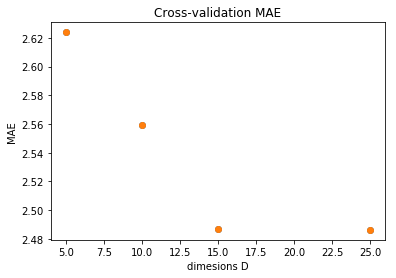

In [289]:
results = pd.read_csv('NMF.csv')
best_values = results.groupby(['param_n_factors'])['mean_test_mae'].min()
plt.plot(best_values,linestyle='none',marker='o')
plt.xlabel('dimesions D')
plt.ylabel('MAE')
plt.title('Cross-validation MAE')
plt.show()

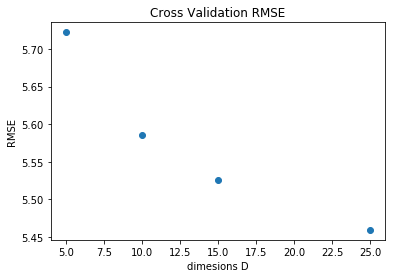

In [290]:
results = pd.read_csv('NMF.csv')
best_values = results.groupby(['param_n_factors'])['mean_test_rmse'].min()
plt.plot(best_values,linestyle='none',marker='o')
plt.xlabel('dimesions D')
plt.ylabel('RMSE')
plt.title('Cross Validation RMSE')
plt.show()

We next explore a k-nearest neighbors-based collaborative filtering model. This method is intuitive because we expect that diabetic patients as well as their typical meals have a lot of latent similarity. We've explored both user-user and item-item based approaches.

In [281]:
#KNN Collaborative Filtering

param_grid = {'bsl_options': {'method': ['sgd'],
                              'reg': [0.5, 2.5,5]},
              'k': [1,5,10,15],
              'n_epochs': [10,30],
              'sim_options': {'name': ['pearson', 'cosine','msd'],
                              'min_support': [1, 5],
                              'user_based': [True,False]}
              }

data = Dataset.load_from_df(finaltraindata[['user', 'item', 'Rating']], reader)
testdata = Dataset.load_from_df(finaltestdata[['user', 'item', 'Rating']], reader)
gs2 = GridSearchCV(KNNWithZScore, param_grid, measures=['rmse', 'mae'], cv=5)
gs2.fit(data)
algokr = gs2.best_estimator['rmse']
res4= pd.DataFrame.from_dict(gs2.cv_results)
res4.to_csv('CF.csv')
trainset = data.build_full_trainset()
algokr.fit(trainset)
predictionskr = algokr.test(trainset.build_testset())
print('Training set accuracy', end='   ')
print(accuracy.rmse(predictionskr))
print(accuracy.mae(predictionskr))


thre=np.mean(finaltraindata['Rating'])
precisions, recalls = precision_recall_at_k(predictionskr, k=50, threshold=thre*0.5)
# Precision and recall can then be averaged over all users
print("Precision and Recall of training set is")
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))


testset = testdata.build_full_trainset()
predictionskr2 = algokr.test(testset.build_testset())
print('Testing Set Accuracy', end='   ')
accuracy.rmse(predictionskr2,verbose=True)
accuracy.mae(predictionskr2,verbose=True)

thre=np.mean(finaltestdata['Rating'])
precisions, recalls = precision_recall_at_k(predictionskr2, k=50, threshold=thre*0.5)
# Precision and recall can then be averaged over all users
print("Precision and Recall of testing set is")
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

Computing the pearson similarity matrix...
Done computing similarity matrix.
Training set accuracy   RMSE: 3.3194
3.3194153335874637
MAE:  0.9054
0.9053515638452496
Precision and Recall of training set is
0.8476929346504567
0.9262144143420169
Testing Set Accuracy   RMSE: 4.4391
MAE:  2.4339
Precision and Recall of testing set is
0.4595418111693628
0.8728595261126699


In [283]:
top_n1 = get_top_n(predictionskr2, n=1600)
finalaverage=0
miss=0
j=0
for i in range(0,len(user_id)):
    prediction=[]
    a=top_n1[i]
    for i in range(0,len(a)):
        c,b=a[i]
        prediction.append(c)
    rank,missing=average_rank(finaltestdata,prediction,user_id[i])
    miss+=missing
    finalaverage+=rank
finalaverage=finalaverage/(finaltestdata['Rating'].sum())
    

print("FinalAveragePercentile rank for Collaborative Filtering is",finalaverage)

FinalAveragePercentile rank for Collaborative Filtering is 0.030719392314566576


Although this is also a very good result as measured by the expected percentile ranking metric, it does not outperform non-negative matrix factorization. 

In fact, non-negative matrix factorization beats the KNN approach according to every metric we're tracking: MAE, RMSE, and expected percentile rank.

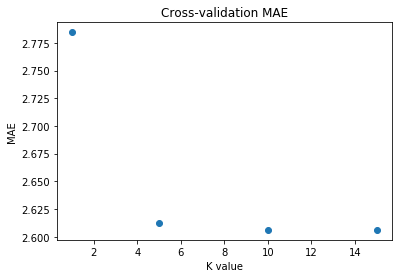

In [292]:
results = pd.read_csv('CF.csv')
best_values = results.groupby(['param_k'])['mean_test_mae'].min()
plt.plot(best_values,linestyle='none',marker='o')
plt.xlabel('K value')
plt.ylabel('MAE')
plt.title('Cross-validation MAE')
plt.show()

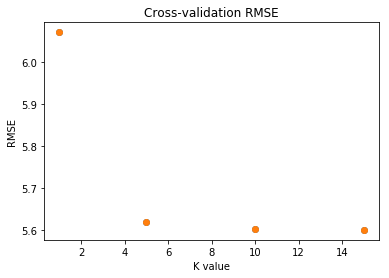

In [294]:
results = pd.read_csv('CF.csv')
best_values = results.groupby(['param_k'])['mean_test_rmse'].min()
plt.plot(best_values,linestyle='none',marker='o')
plt.xlabel('K value')
plt.ylabel('RMSE')
plt.title('Cross-validation RMSE')
plt.show()

The final model we applied to our dataset is factorization machines. We initially believed that this model would outperform all the others. After all, factorization machines are a generalization of the matrix factorization model which was already performing well on our dataset. As we will see, this didn't turn out to be the case.

The repository this implementation was borrowed from is linked here: https://github.com/coreylynch/pyFM

In [295]:
#Last Model Factorzation Machine
demographics = pd.read_csv('Demographic.csv')
preprocessed = pd.read_csv('CombinedData.csv')
demographics.columns

Index(['User ID', 'Gender', 'Age ', 'Weight', 'Height',
       'Calories burnt daily'],
      dtype='object')

In [296]:
demographics.columns = ['user_id','gender','age','weight','height','calories_burnt_daily']
demographics['gender'] = demographics['gender'].map(lambda x:1 if x=='male' else 0)

In [297]:
df = pd.merge(preprocessed,demographics,on="user_id",how="left")

In [298]:
#will be used to impute missing demographic values
mean_values = demographics.mean()


for demographic in demographics.columns:
    df[demographic] = df[demographic].fillna(mean_values[demographic])


In [302]:
train,test = train_test_split(df)

predictors = ['item','carbs','protein','fat','calories','fiber','gender','age','weight','height','calories_burnt_daily']


train_y,test_y = train['Rating'].astype("double"),test['Rating'].astype("double")
train_x,test_x = train[predictors],test[predictors]
v = DictVectorizer()
X_train = v.fit_transform(train_x.to_dict("records"))
X_test = v.transform(test_x.to_dict("records"))

X_train = normalize(X_train)
X_test = normalize(X_test)


#the history dict will keep track of test losses for different hyperparameter values
history = {}


#hyperparameter tuning
for factors in range(5,25,5):
    for iters in [25,50,100]:
        print("Factors = {}, Iters = {}".format(factors,iters))
        fm = pylibfm.FM(num_factors=factors, num_iter=iters, verbose=False, task="regression", initial_learning_rate=0.001, learning_rate_schedule="optimal")
        fm.fit(X_train,train_y)
        preds = fm.predict(X_test)
        error = mean_squared_error(test_y,preds)
        history[(factors,iters)] = error
        print("Test MSE: %.4f" % error)

Factors = 5, Iters = 25
Test MSE: 18.6666
Factors = 5, Iters = 50
Test MSE: 18.7779
Factors = 5, Iters = 100
Test MSE: 18.7382
Factors = 10, Iters = 25
Test MSE: 18.7787
Factors = 10, Iters = 50
Test MSE: 18.7368
Factors = 10, Iters = 100
Test MSE: 18.6904
Factors = 15, Iters = 25
Test MSE: 18.8400
Factors = 15, Iters = 50
Test MSE: 18.6969
Factors = 15, Iters = 100
Test MSE: 18.6875
Factors = 20, Iters = 25
Test MSE: 18.6741
Factors = 20, Iters = 50
Test MSE: 18.9534
Factors = 20, Iters = 100
Test MSE: 18.6995


In [319]:
print("The optimal value of number of factors and the number of iterations is:",min(history,key=op.itemgetter(0)))

The optimal value of number of factors and the number of iterations is: (5, 25)


The best MSE we achieved was 18.67 which corresponds to an RMSE of 4.31, which is very close to the RMSE of 4.35 corresponding to non-negative matrix factorization. So why did the factorization machine not vastly outperform matrix factorization? We believe this is due to overfitting, and that with a larger training set and more user and item meta-deta, the factorization machine would do much better than NMF.

<b> Conclusion: </b>

Our final accuracy according to our primary metrics is sufficiently low that we feel confident putting our models into production. We feel that since this is an ongoing project, as our dataset so will our accuracies. The only concern with putting the system into production currently is its dependence on the Nutritionix API, as well as the TDEE calculator.